In [2]:
sys.path.insert(0, '/lbuc/')
from ulbc import *
from flowstar import *
from ulbc.bondcalculus import *
import numpy as np
import sage.all as sg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math
from scipy.integrate import solve_ivp
from ulbc.matricies import vec_to_numpy, mat_to_numpy, convert_vec, sympy_gens

import sys
sys.path.insert(1, '/lbuc/hostnotebooks/pythonlibs')
from thesissupport.io import loadsys
from thesissupport.plotting import PlottingHandler
from thesissupport.converters import IntervalRemover


ModuleNotFoundError: No module named 'ulbc'

In [2]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import warnings
            
@contextmanager
def suppress_warnings():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yield
        
        
from flowstar.reachability import Reach
from flowstar.poly import Poly
from ulbc import *
from matplotlib.colors import LinearSegmentedColormap

# Load System

In [91]:
bs = loadsys("/lbuc/hostnotebooks/notebooks/models/C_P_DeP_MM.bond", "Pi")
h = PlottingHandler(bs, "Linear")

Running cmd: 'load "/lbuc/hostnotebooks/notebooks/models/C_P_DeP_MM.bond"' ...
Running cmd: 'savesage "Pi" "/tmp/bond-sage-script-ctnqtnn4.py"' ...
System(R, (x0, x1, x2), [0, 1, 1], (((x0 + 0.05000000000000000?)*x1*x2 - x0*(x2 + 0.05000000000000000?))/((x0 + 0.05000000000000000?)*(x2 + 0.05000000000000000?)), 0, -((x0 + 0.05000000000000000?)*x1*x2 - x0*(x2 + 0.05000000000000000?))/((x0 + 0.05000000000000000?)*(x2 + 0.05000000000000000?))), varmap=bidict({'RP': x0, 'S': x1, 'R': x2}))


In [90]:
display(Math(h.d_var_dt('R'))),display(Math(h.d_var_dt('RP').replace('00000000000000','')))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

(None, None)

case5
case7
case8


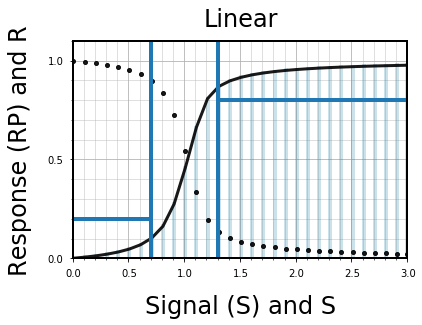

In [81]:
concentration_interval = (0,3,0.1)
time_interval = (0,5,0.1)
fig,ax,_,_ = h.plot("S", conc_interval=concentration_interval, time_interval=time_interval, 
                            speciesX="S", speciesY="RP", 
                            x_label="Signal (S)", y_label="Response (RP)", save=False, continuous=True, xlim=[0,3.001], ylim=[0,1.1001])
fig,ax,_,_ = h.plot("S", conc_interval=concentration_interval, time_interval=time_interval, 
                            speciesX="S", speciesY="R", y_label="R", save=False,not_final=False, continuous=False, xlim=[0,3.001], ylim=[0,1.1001],fig=fig,ax=ax)
ax.axhline(0.2,0,0.23)
ax.axhline(0.8,0.44)
ax.axvline(0.7)
ax.axvline(1.3)

# Reach object

In [92]:
r = bs.with_y0([0,3,1]).reach(10, step=0.01, order=5, precondition=1,
        estimation=1e-5,
        integration_method=IntegrationMethod.NONPOLY_TAYLOR,
        cutoff_threshold=1e-10)

calling reach with y0 = ['[0.0000000000000000 .. -0.0000000000000000]', '[3.0000000000000000 .. 3.0000000000000000]', '[1.0000000000000000 .. 1.0000000000000000]']
ode in symbolic ring
str_odes = ['(x0 + [0.0499999999999999, 0.0500000000000001]*x1*x2 + x0*x2 + [0.0499999999999999, 0.0500000000000001]*[-1.00000000000000, -1.00000000000000])/(x0 + [0.0499999999999999, 0.0500000000000001]*x2 + [0.0499999999999999, 0.0500000000000001])', '[0.000000000000000, 0.000000000000000]', '(-(x0 + [0.0499999999999999, 0.0500000000000001]*x1*x2 + x0*x2 + [0.0499999999999999, 0.0500000000000001]*[-1.00000000000000, -1.00000000000000]))/(x0 + [0.0499999999999999, 0.0500000000000001]*x2 + [0.0499999999999999, 0.0500000000000001])']
crude_roots = False
run = True
_handle_initials called!
vars = ['x0', 'x1', 'x2']
C = [0.0..-0.0]
C = [3.0..3.0]
C = [1.0..1.0]
run within string args
integrationScheme = 4


In [93]:
r.successful

True

In [94]:
r.num_flowpipes

1000

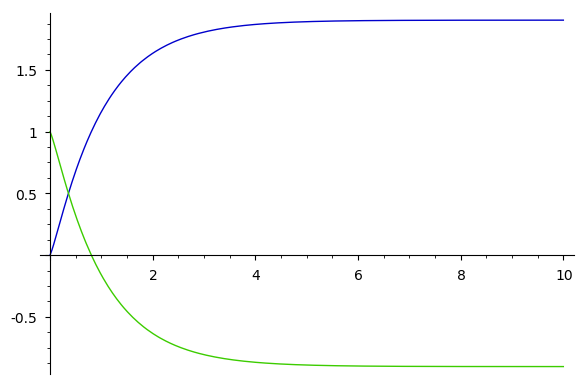

In [95]:
plot((lambda t: r(t)[0].lower(), lambda t: r(t)[0].upper(),lambda t: r(t)[2].lower(), lambda t: r(t)[2].upper()),(0,10))

# Logic

In [6]:
# Separations from lines above
s1 = 0.7
s2 = 1.3
r1 = 0.2
r2 = 0.8

In [24]:
epsilon = 0.1
# Always below asymptote
P1 = G(RIF(0,10),Atomic(var('RP') < 2))

P2 = Atomic(var('RP') < r1)
P3 = Atomic(var('RP') > r2)
P4 = Atomic(var('S') <= s1)
P5 = Atomic(var('S') >= s2)

# R is smaller than r1
P6 = F(RIF(0,10),(G(RIF(0,10),P2)))
# R is bigger than r2
P7 = F(RIF(0,10),(G(RIF(0,10),P3)))

# Eventually, R is smaller than r1 if S is smaller than s1 and R is bigger than r2 if S is bigger than s2.
P8 = F(RIF(0,10),G(RIF(0,10),(Neg(P4) | P2)))
P9 = F(RIF(0,10),G(RIF(0,10),(Neg(P5) | P3)))

propositions = [P1,P2,P3,P4,P5,P6,P7,P8,P9]

In [25]:
P1.signal_for_system(bs.with_y0([0,3,1]), 10, step=0.01, order=5, precondition=1,
        estimation=1e-3,
        integration_method=IntegrationMethod.NONPOLY_TAYLOR,
        cutoff_threshold=1e-5)(0)

Precomposing Contexts: 1 items in 0.00 seconds
calling reach with y0 = ['[0.0000000000000000 .. -0.0000000000000000]', '[3.0000000000000000 .. 3.0000000000000000]', '[1.0000000000000000 .. 1.0000000000000000]']
ode in symbolic ring
str_odes = ['(x0 + [0.0499999999999999, 0.0500000000000001]*x1*x2 + x0*x2 + [0.0499999999999999, 0.0500000000000001]*[-1.00000000000000, -1.00000000000000])/(x0 + [0.0499999999999999, 0.0500000000000001]*x2 + [0.0499999999999999, 0.0500000000000001])', '[0.000000000000000, 0.000000000000000]', '(-(x0 + [0.0499999999999999, 0.0500000000000001]*x1*x2 + x0*x2 + [0.0499999999999999, 0.0500000000000001]*[-1.00000000000000, -1.00000000000000]))/(x0 + [0.0499999999999999, 0.0500000000000001]*x2 + [0.0499999999999999, 0.0500000000000001])']
crude_roots = False
run = True
_handle_initials called!
vars = ['x0', 'x1', 'x2']
C = [0.0..-0.0]
C = [3.0..3.0]
C = [1.0..1.0]
run within string args
integrationScheme = 4
Running Flow*: 1 items in 1.98 seconds
Computed 2001 flo

True

In [ ]:
%%time

start = 0
step = 0.01

steps = 100

solutions = np.ones((len(propositions),steps))*-1

for i in range(steps):
    curr_start = start+i*step
    curr_end = step+i*step
    print('## ', curr_start, curr_end)
    temp_sys = bs.with_y0([0, RIF(curr_start,curr_end), 1])
    #with suppress_stdout():
    for j,p in enumerate(propositions):
        temp_sol = p.context_signal_for_system(
                    temp_sys,
                    10,
                    symbolic_composition=True,
                    restriction_method=RestrictionMethod.SYMBOLIC,
                ).refined_signal(2)(0)
        if temp_sol is None:
            solutions[j,i] = 0
        elif temp_sol is False:
            solutions[j,i] = 1
        elif temp_sol is True:
            solutions[j,i] = 2
        else:
            solutions[j,i] = -1